In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import autogluon as ag
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Config plt to show Chinese
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False


Bad key savefig.frameon in file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.

## Read Data

In [2]:
df = pd.read_excel('online_education_learning_233.xlsx')

df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2926
Data columns (total 8 columns):
19、(按时完成和提交作业)                         2927 non-null int64
19、(课后与同学讨论课程相关问题和思考)                  2927 non-null int64
19、(课后联系老师请教课程疑问)                      2927 non-null int64
19、(课后利用相关资料开展自主学习)                    2927 non-null int64
20、(课前提供了充足的课程阅读文献资料)                  2927 non-null int64
20、(课前提供了详尽的课程说明（包括教学平台使用说明）)          2927 non-null int64
20、(课程内容浓缩微型化，适应在线学习注意力时长并合理设置课间休息)    2927 non-null int64
20、(课程内容呈现形式更为多样化)                     2927 non-null int64
dtypes: int64(8)
memory usage: 205.8 KB


# Conventional Method

## Adequacy Test

In [3]:
_, pValue = calculate_bartlett_sphericity(df)
_, KMOModel = calculate_kmo(df)
print('pValue is %f (< 0.01 means excellent)' % pValue)
print('KMOModel is %f (> 0.8 means excellent)' % KMOModel)

pValue is 0.000000 (< 0.01 means excellent)
KMOModel is 0.851671 (> 0.8 means excellent)


## Decide How Many Factors to Use

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/factor_analyzer.py:342: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  error = sp.sum(residual)


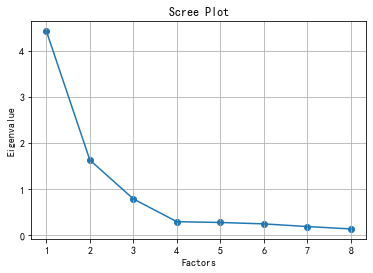

In [4]:
fa = FactorAnalyzer(25, rotation=None)
fa.fit(df)
ev, v = fa.get_eigenvalues()

# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/factor_analyzer.py:342: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  error = sp.sum(residual)


Total Variance Explained



array([0.39233576, 0.65702166, 0.74784071])

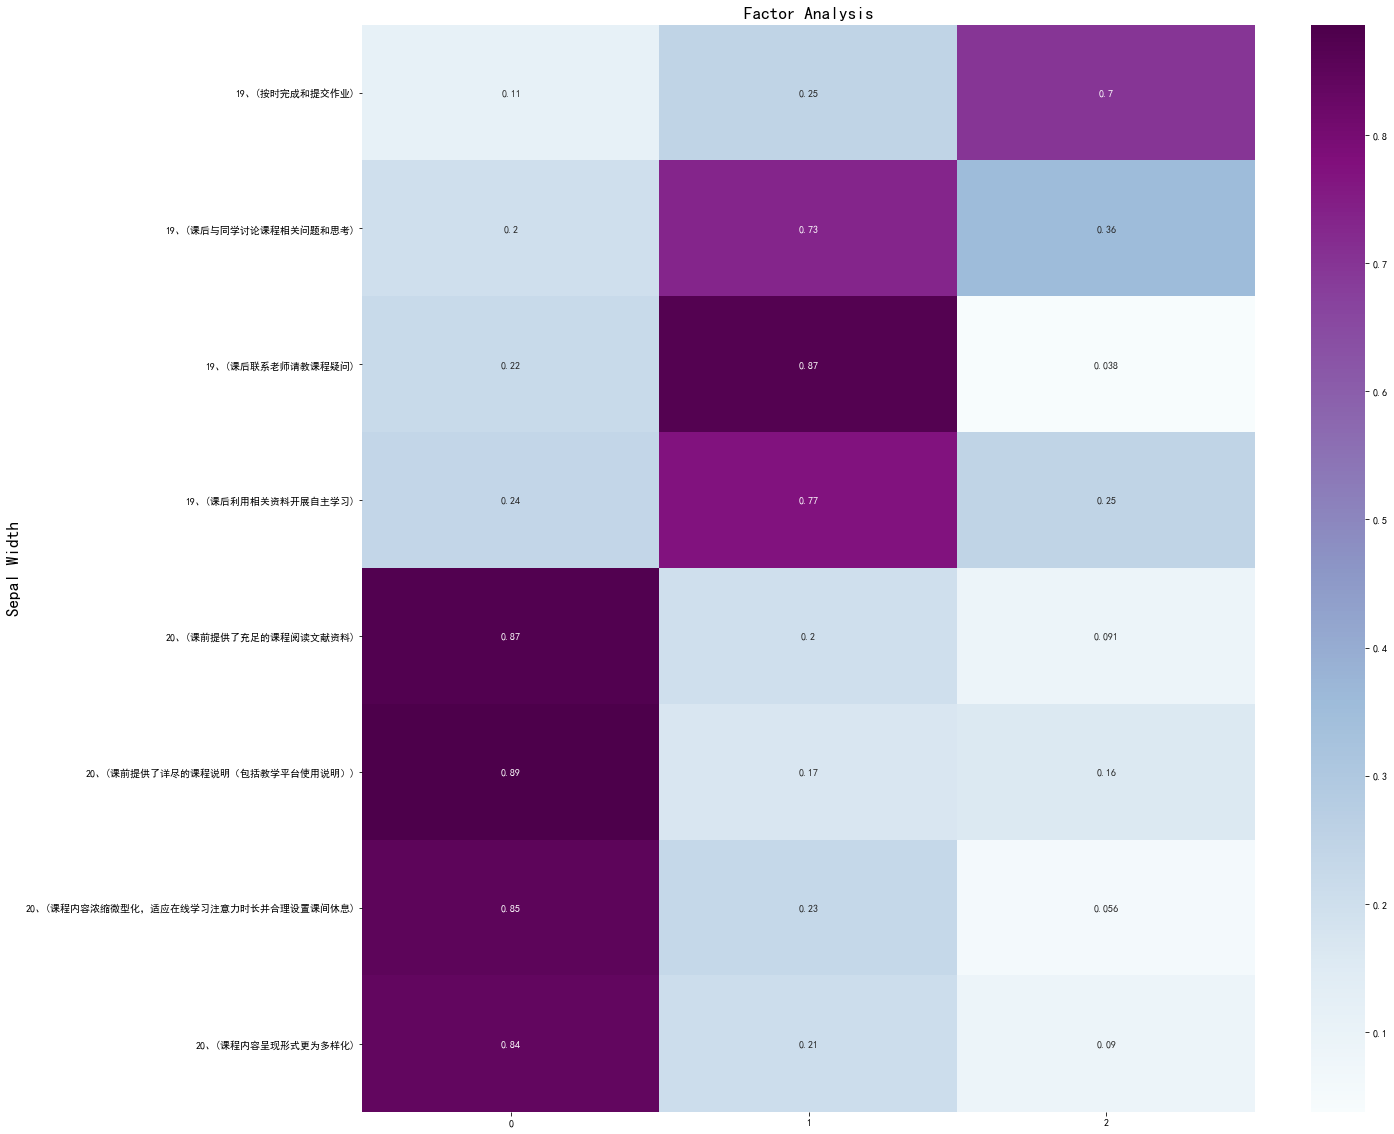

In [5]:
fa = FactorAnalyzer(3, rotation="varimax")
fa.fit(df)

df_cm = pd.DataFrame(np.abs(fa.loadings_), index=df.columns)
plt.figure(figsize = (20,20))
ax = sns.heatmap(df_cm, annot=True, cmap="BuPu")
plt.title('Factor Analysis', fontsize='xx-large')
plt.ylabel('Sepal Width', fontsize='xx-large')

print('Total Variance Explained\n')
fa.get_factor_variance()[2]

# NAS Approach

## Specify the Search Space

In [6]:
factorNum = 3
varNum = 8

varNames = df.columns

searchVar = dict(zip(
    [str(i) for i in range(varNum)], 
    [ag.space.Categorical(*list(range(factorNum))) for i in range(varNum)]))

@ag.args(**searchVar)
def rl_simulation(args, reporter):
    model_dict = dict(zip(
        [str(i) for i in range(factorNum)], 
        [[] for i in range(factorNum)]))
        
    for var, factor in args.items():
        if (var == 'task_id'): continue
#         print(var, factor)
        model_dict[str(factor)].append(varNames[int(var)])

    model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df, model_dict)

    cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 
    cfa.fit(df.values) 

#     cfa.get_model_implied_cov()
#     cfa.loadings_
#     print(cfa.bic_)
#     print(cfa.aic_)
#     print(cfa.loadings_)
    
    if (math.isnan(cfa.bic_)):
        reporter(accuracy=0)
    else:
        reporter(accuracy=1/(cfa.bic_/10000.0))

In [7]:
random_scheduler = ag.scheduler.FIFOScheduler(rl_simulation,
                                              resource={'num_cpus': 1, 'num_gpus': 0},
                                              num_trials=6000,
                                              reward_attr='accuracy')
random_scheduler.run()
random_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(random_scheduler.get_best_config(), random_scheduler.get_best_reward()))

mmp = random_scheduler.get_best_config()
for x in range(varNum):
    y = mmp[str(x) + '.choice']
    print(x, y)

scheduler_options: Key 'searcher': Imputing default value random
scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'time_attr': Imputing default value epoch
scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 6000


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

Best config: {'0.choice': 2, '1.choice': 1, '2.choice': 0, '3.choice': 1, '4.choice': 0, '5.choice': 2, '6.choice': 2, '7.choice': 2}, best reward: 0.15797230225527154
0 2
1 1
2 0
3 1
4 0
5 2
6 2
7 2


In [8]:
rl_scheduler = ag.scheduler.RLScheduler(rl_simulation,
                                        resource={'num_cpus': 1, 'num_gpus': 0},
                                        num_trials=6000,
                                        reward_attr='accuracy',
                                        controller_batch_size=4,
                                        time_attr='epoch',
                                        controller_lr=5e-3,
                                        checkpoint='./checkerpoint.ag')
rl_scheduler.run()
rl_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(rl_scheduler.get_best_config(), rl_scheduler.get_best_reward()))

mmp = rl_scheduler.get_best_config()
for x in range(varNum):
    y = mmp[str(x) + '.choice']
    print(x, y)

scheduler_options: Key 'resume': Imputing default value False
scheduler_options: Key 'ema_baseline_decay': Imputing default value 0.95
scheduler_options: Key 'controller_resource': Imputing default value {'num_cpus': 0, 'num_gpus': 0}
scheduler_options: Key 'sync': Imputing default value True

scheduler_options: Key 'visualizer': Imputing default value none
scheduler_options: Key 'training_history_callback_delta_secs': Imputing default value 60
scheduler_options: Key 'delay_get_config': Imputing default value True

Reserved DistributedResource(
	Node = Remote REMOTE_ID: 0, 
	<Remote: 'inproc://192.168.2.94/49009/1' processes=1 threads=12, memory=17.18 GB>
	nCPUs = 0) in Remote REMOTE_ID: 0, 
	<Remote: 'inproc://192.168.2.94/49009/1' processes=1 threads=12, memory=17.18 GB>
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 6000


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'AB


Best config: {'0.choice': 2, '1.choice': 2, '2.choice': 1, '3.choice': 1, '4.choice': 2, '5.choice': 2, '6.choice': 1, '7.choice': 1}, best reward: 0.15797230225527154
0 2
1 2
2 1
3 1
4 2
5 2
6 1
7 1


In [9]:
results_rl = [v[0]['accuracy'] for v in rl_scheduler.training_history.values()]
results_random = [v[0]['accuracy'] for v in random_scheduler.training_history.values()]

In [10]:
results1 = [np.max(results_random[i:i+10]) for i in range(0, len(results_random), 10)]
results2 = [np.max(results_rl[i:i+10]) for i in range(0, len(results_rl), 10)]

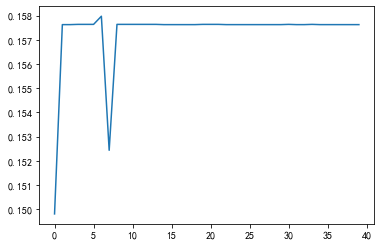

In [16]:
plt.plot(range(40), results2[:40])